##Imports

In [15]:
import os, shutil, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

## Mounted Data


In [16]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
zip_filename = "/content/drive/MyDrive/content/HAM10000.zip"
with ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall()
    print("Dataset extracted.")

Dataset extracted.


# Load metadata, preprocessing and prepare train/test splits

In [18]:
data_pd = pd.read_csv('/content/drive/MyDrive/content/HAM10000_metadata.csv')
print("Metadata loaded. Sample:")
print(data_pd.head())


# Remove duplicate lesions: keep only those lesion_ids with a count of 1
df_count = data_pd.groupby('lesion_id').count().reset_index()
df_count = df_count[df_count['dx'] == 1]

def duplicates(x):
    unique = set(df_count['lesion_id'])
    return 'no' if x in unique else 'duplicate'

data_pd['is_duplicate'] = data_pd['lesion_id'].apply(duplicates)
data_pd = data_pd[data_pd['is_duplicate'] == 'no']


train_df, test_df = train_test_split(data_pd, test_size=0.15, stratify=data_pd['dx'], random_state=42)

# Mark images as train or test based on split
def identify_trainOrtest(image_id):
    test_ids = set(test_df['image_id'].astype(str))
    return 'test' if str(image_id) in test_ids else 'train'

data_pd['train_test_split'] = data_pd['image_id'].apply(identify_trainOrtest)
train_df = data_pd[data_pd['train_test_split'] == 'train']

# Set image_id as index for easier lookup of labels
data_pd.set_index('image_id', inplace=True)

data_pd

Metadata loaded. Sample:
     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


,lesion_id,dx,dx_type,age,sex,localization,is_duplicate,train_test_split
image_id,,,,,,,,
ISIC_0025276,HAM_0001396,bkl,histo,55.0,female,trunk,no,train
ISIC_0031326,HAM_0007207,bkl,histo,65.0,male,back,no,train
ISIC_0032343,HAM_0006071,bkl,histo,70.0,female,face,no,train
ISIC_0024981,HAM_0005612,bkl,histo,80.0,male,scalp,no,test
ISIC_0027815,HAM_0005388,bkl,histo,80.0,male,chest,no,train
...,...,...,...,...,...,...,...,...
ISIC_0027588,HAM_0001036,akiec,histo,50.0,female,face,no,train
ISIC_0027334,HAM_0004462,akiec,histo,45.0,male,trunk,no,train
ISIC_0030133,HAM_0001152,akiec,histo,65.0,male,face,no,train


# Create directories and copy images for training and testing

In [19]:
base_dir = 'HAM10000'
train_dir = os.path.join(base_dir, 'train_dir')
test_dir = os.path.join(base_dir, 'test_dir')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

## Creating Directories for train and test to save RAM


In [20]:
targetnames = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
for label in targetnames:
    os.makedirs(os.path.join(train_dir, label), exist_ok=True)
    os.makedirs(os.path.join(test_dir, label), exist_ok=True)

# Get lists of image IDs for train and test sets
train_list = list(train_df['image_id'])
test_list = list(test_df['image_id'])

# Copy images to the train directories
for image in train_list:
    file_name = image + '.jpg'
    label = data_pd.loc[image, 'dx']
    source = os.path.join(base_dir, file_name)
    target = os.path.join(train_dir, label, file_name)
    if os.path.exists(source):
        shutil.copyfile(source, target)
    else:
        print("File not found:", source)

# Copy images to the test directories
for image in test_list:
    file_name = image + '.jpg'
    label = data_pd.loc[image, 'dx']
    source = os.path.join(base_dir, file_name)
    target = os.path.join(test_dir, label, file_name)
    if os.path.exists(source):
        shutil.copyfile(source, target)
    else:
        print("File not found:", source)

print("Images copied to train and test directories.")

Images copied to train and test directories.


#Data Augmentation

In [7]:
image_size = 224
label_to_index = {label: idx for idx, label in enumerate(targetnames)}

X_train_list = []
y_train_list = []

random.seed(42)
np.random.seed(42)

for label in targetnames:
    class_dir = os.path.join(train_dir, label)
    file_list = os.listdir(class_dir)

    # Sample 500 images (if there are fewer, sample with replacement)
    if len(file_list) >= 500:
        sampled_files = random.sample(file_list, 500)
    else:
        sampled_files = list(np.random.choice(file_list, size=500, replace=True))

    for file in sampled_files:
        img_path = os.path.join(class_dir, file)
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img)
        X_train_list.append(img_array)
        y_train_list.append(label_to_index[label])

# Convert lists to numpy arrays and normalize pixel values to [0,1]
X_train = np.array(X_train_list, dtype=np.float32) / 255.0
y_train = np.array(y_train_list)
y_train_cat = to_categorical(y_train, num_classes=len(targetnames))
print("Balanced training set created with {} images.".format(X_train.shape[0]))

Balanced training set created with 3500 images.


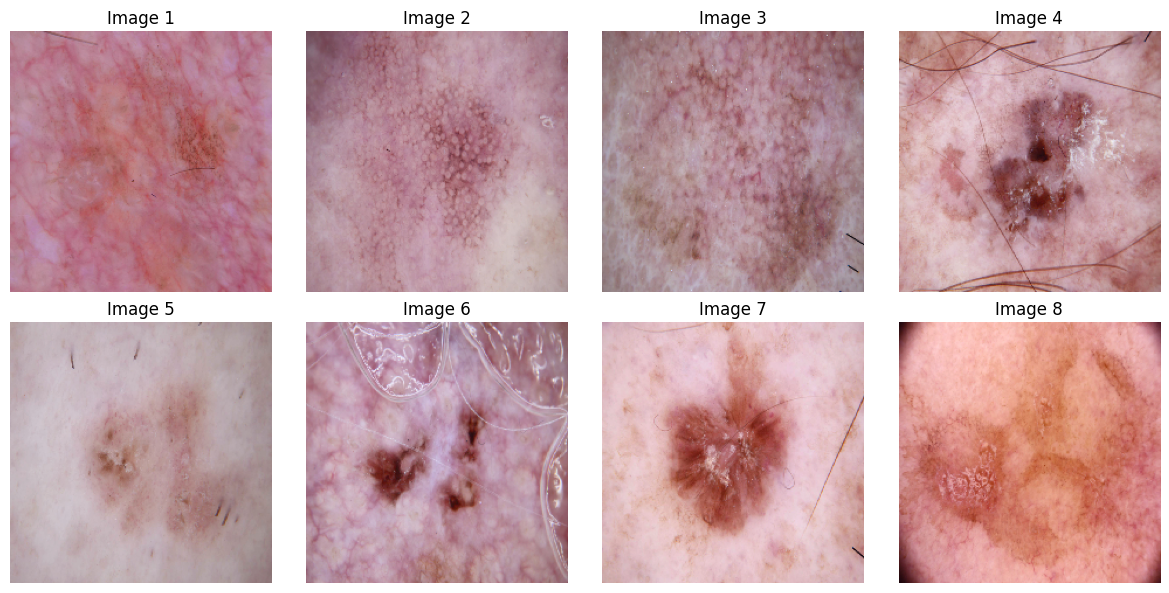

In [8]:
# Create a 2x4 grid for the images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.flatten()

# Loop over the first 8 images and plot each one
for i in range(8):
    axes[i].imshow(X_train[i])
    axes[i].axis('off')
    axes[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

# Load test images using ImageDataGenerator

In [ ]:
batch_size = 16
test_datagen = ImageDataGenerator(rescale=1./255)

test_batches = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

X_test_list = []
y_test_list = []
for i in range(len(test_batches)):
    X_batch, y_batch = next(test_batches)
    X_test_list.append(X_batch)
    y_test_list.append(y_batch)
X_test = np.concatenate(X_test_list, axis=0)

y_test = np.concatenate(y_test_list, axis=0)
y_test_labels = np.argmax(y_test, axis=1)
y_test_cat = np.concatenate(y_test_list, axis=0)


print("Test set loaded with {} images.".format(X_test.shape[0]))


In [ ]:
y_test_cat.shape

(828, 7)

# Logistical Regression Model


In [ ]:
# Flatten images for scikit-learn Logistic Regression

X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Train logistic regression using scikit-learn
clf = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=100, verbose=1, n_jobs=-1)
clf.fit(X_train_flat, y_train)

# Predict on test data and print the test accuracy
y_pred = clf.predict(X_test_flat)
accuracy = accuracy_score(y_test_labels, y_pred)
print("\nTest Accuracy: {:.4f}".format(accuracy))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


max_iter reached after 2209 seconds

Test Accuracy: 0.6787


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


# Neural Network Model

In [ ]:
model = Sequential([
    Input(shape=(image_size, image_size, 3)), #Input layer
    Flatten(),                                #Turns into flatten array
    Dense(1024, activation='relu'),           # Hidden layers
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(targetnames), activation='softmax')
])

opt = Adam(learning_rate=0.001, epsilon=0.1)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"], run_eagerly=True)
                              #loss function used

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 150528)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │     154,141,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 154,839,431 (590.67 MB)

 Trainable params: 154,839,431 (590.67 MB)

 Non-trainable params: 0 (0.00 B)

Relu here is the activation formula

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
checkpoint = ModelCheckpoint('T2v.weights.h5', monitor='val_loss', save_weights_only=True,save_best_only=True, mode='min')

history = model.fit(X_train, y_train_cat, epochs=50, batch_size=32, validation_data=(X_test, y_test_cat), verbose=1, callbacks=[checkpoint])

model.load_weights("T2v.weights.h5")
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print("\nTest Accuracy: {:.4f}".format(test_accuracy))

Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.1907 - loss: 1.9358 - val_accuracy: 0.7403 - val_loss: 1.3214
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.2327 - loss: 1.8514 - val_accuracy: 0.4928 - val_loss: 1.7114
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.3420 - loss: 1.7215 - val_accuracy: 0.6425 - val_loss: 1.2358
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - accuracy: 0.3444 - loss: 1.6939 - val_accuracy: 0.3406 - val_loss: 1.8015
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.3781 - loss: 1.6283 - val_accuracy: 0.4287 - val_loss: 1.5627
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 13s 121ms/step - accuracy: 0.3923 - loss: 1.5512 - val_accuracy: 0.6848 - val_loss: 0.8753
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - accuracy: 0.4241 - loss: 1.5045 - val_accuracy: 0.5688 - val_loss: 1.2562
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.4596 - loss: 1.4486

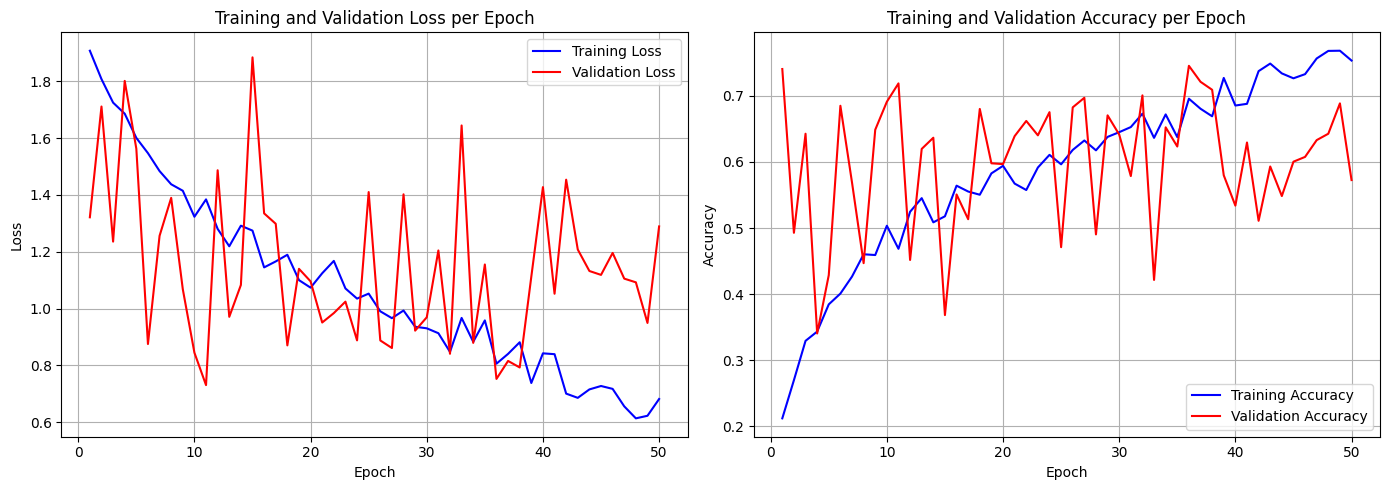

In [ ]:
import matplotlib.pyplot as plt

# Extract data from training history
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

# Set up the figure
plt.figure(figsize=(14, 5))

# 🔹 Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# 🔹 Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Training and Validation Loss per Epoch -
In this plot we can see that the training loss goes down over time meaning the model is making less and less errors with each epoch. That being said the Validation loss line is going up with each epoch which can indicate overfitting.
Validation is when we take the model and check how it is doing on unseen data.
Overfitting means that the model performs well on training data but not on unseen data.

Training and Validation Accuracy - In this plot we can see when our model predicates correctly. Here we want to see both lines come together closely, if the validation line is having big spikes its a sign of overfitting. From both of these plot graphs we can assume that 25-30 epoch is where we want to end our training to counter overfitting.

# Second Model Run with Lower Epoch

In [ ]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
checkpoint = ModelCheckpoint('T2v.weights.h5', monitor='val_loss', save_weights_only=True,save_best_only=True, mode='min')

history = model.fit(X_train, y_train_cat, epochs=25, batch_size=32, validation_data=(X_test, y_test_cat), verbose=1, callbacks=[checkpoint])

model.load_weights("T2v.weights.h5")
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print("\nTest Accuracy: {:.4f}".format(test_accuracy))

# CNN

Data Augmentation

In [21]:
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

aug_dir = 'aug_dir'
image_size = 224
max_data = 8000

# Create output directory if it doesn't exist
os.makedirs(aug_dir, exist_ok=True)

# Create label-index mapping (only needed if you wish to keep track of numeric labels)
label_to_index = {label: idx for idx, label in enumerate(targetnames)}

# Define data augmentation
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

for label in targetnames:
    # Create class subfolder in aug_dir
    label_output_dir = os.path.join(aug_dir, label)
    os.makedirs(label_output_dir, exist_ok=True)

    # Get list of images in the original training folder for this label
    class_dir = os.path.join(train_dir, label)
    file_list = os.listdir(class_dir)

    images_for_class = []
    for file_name in file_list:
        img_path = os.path.join(class_dir, file_name)
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img)
        images_for_class.append(img_array)

    # Convert list to array
    X_all = np.array(images_for_class, dtype=np.float32)

    n_images = len(X_all)

    # ---------------------------
    # CASE 1: If more than max_data
    # ---------------------------
    if n_images > max_data:
        # Randomly sample max_data images
        selected_indices = random.sample(range(n_images), max_data)
        X_selected = X_all[selected_indices]

        # Save these 2000 (randomly selected) images to aug_dir
        for i, img_array in enumerate(X_selected):
            out_path = os.path.join(label_output_dir, f'original_{i}.jpg')
            save_img(out_path, img_array)

        print(f"Saved {max_data} images (random sample) for class '{label}'.")

    # ---------------------------
    # CASE 2: If fewer than max_data
    # ---------------------------
    elif n_images < max_data:
        # Save all existing images first
        for i, img_array in enumerate(X_all):
            out_path = os.path.join(label_output_dir, f'original_{i}.jpg')
            save_img(out_path, img_array)

        # Now figure out how many augmented images are needed
        needed = max_data - n_images

        # Create a small generator for augmentation
        gen = datagen.flow(X_all, batch_size=1, shuffle=True)

        # Generate and save the augmented images
        for i in range(needed):
            X_aug = next(gen)[0]  # gen outputs a batch of 1, shape (1, H, W, C)
            out_path = os.path.join(label_output_dir, f'aug_{i}.jpg')
            save_img(out_path, X_aug)

        print(f"Saved {n_images} original + {needed} augmented images for class '{label}' (total {max_data}).")

    # ---------------------------
    # CASE 3: Exactly max_data
    # ---------------------------
    else:  # n_images == max_data
        for i, img_array in enumerate(X_all):
            out_path = os.path.join(label_output_dir, f'original_{i}.jpg')
            save_img(out_path, img_array)

        print(f"Exactly {max_data} images found for class '{label}', all saved with no augmentation.")

print("Augmented dataset successfully created in:", aug_dir)


Saved 128 original + 7872 augmented images for class 'akiec' (total 8000).
Saved 149 original + 7851 augmented images for class 'bcc' (total 8000).
Saved 374 original + 7626 augmented images for class 'bkl' (total 8000).
Saved 33 original + 7967 augmented images for class 'df' (total 8000).
Saved 196 original + 7804 augmented images for class 'mel' (total 8000).
Saved 3752 original + 4248 augmented images for class 'nv' (total 8000).
Saved 54 original + 7946 augmented images for class 'vasc' (total 8000).
Augmented dataset successfully created in: aug_dir


In [22]:
batch_size = 16
image_size = 224

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    aug_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 56000 images belonging to 7 classes.
Found 828 images belonging to 7 classes.


In [23]:
model = Sequential([
    Input(shape=(image_size, image_size, 3)),

    # Block 1
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # Block 2
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),

    # Block 3
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),


    # Block 4
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    Conv2D(512, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),


    # Classification Block
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(targetnames), activation='softmax')
])


opt1=tf.keras.optimizers.Adam(learning_rate=0.01,epsilon=0.9)
model.compile(optimizer=opt1,loss='categorical_crossentropy',metrics=['accuracy'])

Each Block of the model is learning a different pattern. The blocks includes a 2d conventional layer as well as a pooling one. The Conv2d layer is a filter that helps learn a specfic pattern. The pooling reduces the size of the image while keeping what is important. The clasifiction block makes a prediction it flattens the image uses Dense which connects all the neurons and uses activaction relu. It then drops about 50 of the neurons to prevent overfitting. And then it finally outputs.

In [34]:
from datetime import datetime
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

# Add a timestamp to make the filename unique each run
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(f'Best_CNN_{timestamp}.weights.h5',
                             monitor='val_accuracy',
                             save_weights_only=True,
                             save_best_only=True,
                             mode='max')


In [35]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    epochs=10,
    callbacks=[checkpoint],
    verbose=1
)


Epoch 1/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 99s 28ms/step - accuracy: 0.6996 - loss: 0.7580 - val_accuracy: 0.5257 - val_loss: 1.1441
Epoch 2/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 98s 28ms/step - accuracy: 0.7496 - loss: 0.6350 - val_accuracy: 0.6777 - val_loss: 0.9689
Epoch 3/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 98s 28ms/step - accuracy: 0.7959 - loss: 0.5270 - val_accuracy: 0.6801 - val_loss: 0.9118
Epoch 4/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 98s 28ms/step - accuracy: 0.8370 - loss: 0.4265 - val_accuracy: 0.7304 - val_loss: 0.7824
Epoch 5/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 97s 28ms/step - accuracy: 0.8764 - loss: 0.3338 - val_accuracy: 0.6483 - val_loss: 1.0499
Epoch 6/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 99s 28ms/step - accuracy: 0.9054 - loss: 0.2577 - val_accuracy: 0.7525 - val_loss: 0.8339
Epoch 7/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 99s 28ms/step - accuracy: 0.9227 - loss: 0.2085 - val_accuracy: 0.7696 - val_loss: 0.7694
Epoch 8/10
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 100s 29ms/step - accuracy: 0.9378 

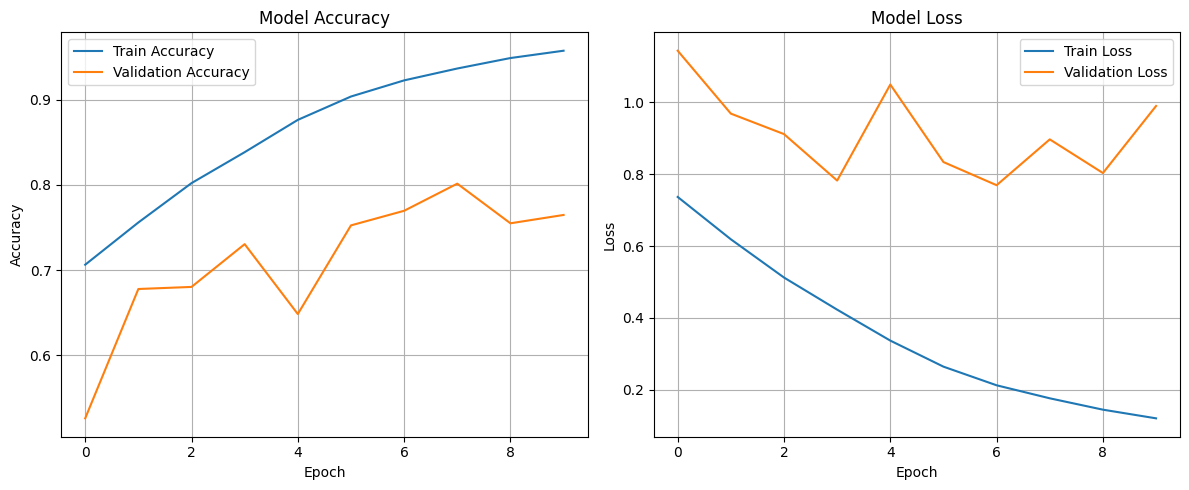

In [36]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [39]:
# Load the best weights
model.load_weights(f"Best_CNN_{timestamp}.weights.h5")

# Evaluate using the test generator (no X_test, y_test_cat arrays needed)
test_loss, test_accuracy = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size,
    verbose=0
)

print(f"\nTest Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.8015
